In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import gensim
import csv
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import pickle
import random
import math
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [21]:
no_classes = 5
no_ingredients = 11744  # for 5 classes
hidden_layer = int(math.sqrt(no_classes*no_ingredients))

# set up the number of recipes you need for each experiment, and the number of experiments
recipes_to_transform = 100
number_of_experiments = 1

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(no_ingredients, hidden_layer),
      nn.ReLU(),
      nn.Linear(hidden_layer, no_classes)
    )

  def forward(self, x):
    '''Forward pass'''
    x=torch.squeeze(x).float()
    x=self.layers(x)
    # x = F.softmax(x)
    return x

def ret_vec_for_model(ing_list):
    a=np.zeros(no_ingredients,dtype=float)
    for i in ing_list:
        a[ing_dict[i]] = 1
    a=torch.from_numpy(a)
    return a


# READ REQUIRED DATA

In [22]:

f=open("Cuisine Fusion Data/region_dict5.data",'rb')
reg_dict=pickle.load(f)

f=open("Cuisine Fusion Data/ingredint_dict5.data",'rb')
ing_dict=pickle.load(f)

f=open('Cuisine Fusion Data/percentage_dict5.data','rb')
percentage_dict = pickle.load(f)

f=open("Cuisine Fusion Data/tdata5.data",'rb')
tdata=pickle.load(f)
tdata = list(tdata.items())

f=open("Cuisine Fusion Data/nn_model5.m",'rb')
pred_model=pickle.load(f)

# f=open("../data/w2vec5.m",'rb') 
# tran_model=pickle.load(f)



KeyboardInterrupt



In [30]:
len(tdata)

51349

In [27]:
tdata[46389]

(95149,
 ['South_American',
  'beef',
  'garlic_clove',
  'taco_seasoning',
  'bean',
  'cream_mushroom_soup',
  'salsa',
  'cheese',
  'jalapeno',
  'black_olive'])

In [29]:
model = gensim.models.Word2Vec(tdata[:100],vector_size=100, window=40, min_count=1)
model.build_vocab(tdata[:100], progress_per=1000)
print("Created vocab")
# print("Corpus count= ", model.corpus_count)  ##118083

print("Training started for " + str(5))
model.train(tdata[:100],total_examples=model.corpus_count, epochs=5)
print("Training complete")



KeyboardInterrupt



In [4]:
## it is a dictionary of dictionaries
ing_file = 'All_Ing_Inst_Emb_Dict.pkl'

with open(ing_file, 'rb') as file:
    ing_emb_dict = pickle.load(file)


In [5]:


## it is a dictionary
cuisine_file = 'Cuisine_Mean_Emb_SBERT.pkl'

with open(cuisine_file, 'rb') as file:
    cuisine_emb_dict = pickle.load(file)


In [6]:
for key1,_ in cuisine_emb_dict.items():
    for key2,_ in cuisine_emb_dict.items():
        similarity= cosine_similarity(cuisine_emb_dict[key1].reshape(1,-1),cuisine_emb_dict[key2].reshape(1,-1))
        print(f"Cosine Similarity between {key1} and {key2} ",similarity)

Cosine Similarity between Italian and Italian  [[1.]]
Cosine Similarity between Italian and Mexican  [[0.96509419]]
Cosine Similarity between Italian and Canadian  [[0.95004395]]
Cosine Similarity between Italian and South_American  [[0.96455813]]
Cosine Similarity between Italian and Indian_Subcontinent  [[0.93616573]]
Cosine Similarity between Mexican and Italian  [[0.96509419]]
Cosine Similarity between Mexican and Mexican  [[1.]]
Cosine Similarity between Mexican and Canadian  [[0.95653124]]
Cosine Similarity between Mexican and South_American  [[0.97123027]]
Cosine Similarity between Mexican and Indian_Subcontinent  [[0.94681934]]
Cosine Similarity between Canadian and Italian  [[0.95004395]]
Cosine Similarity between Canadian and Mexican  [[0.95653124]]
Cosine Similarity between Canadian and Canadian  [[1.]]
Cosine Similarity between Canadian and South_American  [[0.94565368]]
Cosine Similarity between Canadian and Indian_Subcontinent  [[0.95129737]]
Cosine Similarity between Sou

## CREATING A CSV FILE FOR RECIPE TRANFORMATION

In [7]:
# creating a list of all the cuisines (It is stored as the key in our region_dict)

cuisine_list = list()
for key in reg_dict:
    cuisine_list.append(key)

#total data = total recipes * total experiments * number of fusions

total_data = recipes_to_transform * number_of_experiments * 20

f = open('sbert_new_inst_assess_table_'+str(total_data)+'_BERT.csv','w')
writer = csv.writer(f)

columns = ['Experiment Number','Recipe_ID','Source','Target','No of Ingredients','Success/Failure','Steps take for success','Confidence of Success','Transformed Ingredients']
writer.writerow(columns)


146

In [8]:
# sort the tdata based on the cuisine name
tdata = sorted(tdata,key = lambda x:x[1][0])

# create a dictionary which contains the index range of recipes for each cuisine 

index_dict = dict()
start = -1
end = 0
for i in range(len(tdata)):
    if(start == -1):
        start = i
    if(i==len(tdata)-1 or tdata[i][1][0] != tdata[i+1][1][0]):
        index_dict[tdata[i][1][0]] = (start,i)
        start = -1

In [9]:
index_dict

{'Canadian': (0, 6693),
 'Indian_Subcontinent': (6694, 13156),
 'Italian': (13157, 29730),
 'Mexican': (29731, 44177),
 'South_American': (44178, 51348)}

## EXPERIMENT START

In [10]:
def find_replacement(original_ing, original_cuisine, target_cuisine, ing_emb_dict, cuisine_emb_dict):
  
    # reqd = ing_vector + target_cuisine_vector - original_cuisine_vector
    required_emb = ing_emb_dict[original_cuisine][original_ing] - cuisine_emb_dict[original_cuisine] + cuisine_emb_dict[target_cuisine]

    new_ing = None
    max_cos_sim = 0

    if target_cuisine in ing_emb_dict:
        target_ing_dict = ing_emb_dict[target_cuisine]

        for key, value in target_ing_dict.items():  
              cos_sim = cosine_similarity([required_emb], [value])
              if key==original_ing:
                continue
              else:  
            

                   if cos_sim > max_cos_sim:
                        max_cos_sim = cos_sim
                        new_ing = key
    return new_ing

In [11]:
test_str="a"
test_dict= {"a":1,"b":2}

for key,_ in test_dict.items():
    print(key is test_str)

True
False


In [12]:
'salt' is not 'salt'   

False

In [13]:
'Canadian' in ing_emb_dict

True

In [14]:
find_replacement('salt', 'Italian', 'Mexican', ing_emb_dict, cuisine_emb_dict)

'white_corn_syrup'

In [15]:
'''
In each experiment, for each of the cuisine pair, first set the source and target cuisine.
Then we select a 'recipe_num' randomally from the source cuisine's recipes (which has not already been processed),
and then get it's ingredient list. We then create ing_percent_dict, which stores the relevance of that ingredient 
in the source cuisine. We then sort our ing_list in decreasing order of the value from ing_percent_dict. 
For each of the mutation we pick the first ing from our list and then find its "most similar" replacement from 
the target cuisine using the transformation model (here word2vec). 

The old list of ingredients is updated by replacing the ingredient with the new ingredient, and this list is provided
as input to the prediction model for predicting the cuisine. If the predicted cuisine is same as the targeted cuisine, 
the experient is successful and thus move on to next experiment, otherwise the same experiment continues with the 
next mutation (i.e go on by replacing the next ingredient in the same way)

For a experiment we store the 'steps' needed to make it a successful conversion (count of ingredients needed to be replaced),
also the 'confidence' value stores the confidence with which the cuisine is predicted. 
And we also store the list of pair of ingredients being replaced with new ingredients.

'''


print("Starting Experiment")
recipe_written = 0
for exp in tqdm(range(number_of_experiments)):
    for ind1 in range(len(cuisine_list)):
        # print(f"I IS {i}")
        for ind2 in range(len(cuisine_list)):
            if(ind1!=ind2):
                # print(i)
                # print(cuisine_list)
                source = cuisine_list[ind1]
                target = cuisine_list[ind2]
                # flag = False
                recipe_count = 0
                done = []
                z = 0
                while recipe_count != recipes_to_transform:
                    ingredientFromTo = {}

                    # print(type(index_dict[source][0]))
                    # print(type(k))
                    # recipe_num = random.randint(index_dict[source][0] , index_dict[source][1] )
                    recipe_num = index_dict[source][0]
                    while recipe_num in done: 
                        recipe_num = random.randint(index_dict[source][0] , index_dict[source][1] )
                    done.append(recipe_num)
                    recipe = tdata[recipe_num][1]
                    z += 1
                    ingredients_orig = recipe[1:]
                    cuisine_orig = recipe[0]
                    ing_percent_dict = dict()
                    for ing in ingredients_orig:
                        ing_percent_dict[ing] = percentage_dict[cuisine_orig][ing]
                        
                    ingredients_new = ingredients_orig.copy()
                    cuisine_new = target
                    count = 0
                    status = 'Failure'
                    steps = 0
                    confidence = 0
                    for k in sorted(ing_percent_dict,key = ing_percent_dict.get,reverse = True):
                        
                        try:
                            ## TO BE REPLACED FOR GETTING REPLACEMENT USING BERT MODEL

                            # result = tran_model.wv.most_similar(positive=[cuisine_new,k],negative=[cuisine_orig],topn=7)
                            # print(k)
                            # print(cuisine_orig)
                            # print(cuisine_new)
                            # break
                            result = find_replacement(k, cuisine_orig, cuisine_new, ing_emb_dict, cuisine_emb_dict)
                            # print(result)
                        except:
                            print("This recipe failed")
                            continue
                        
                        new_ing = ''
                        
                        # Check if the new_ing is not the name of any cuisine or blank
                        
                        # for tup in result:
                        #     if(tup[0] not in reg_dict.keys()):
                        #         new_ing = tup[0]
                        #         break
                        if result not in reg_dict.keys():
                            new_ing = result
                        
                        if(new_ing == ''):
                            continue
                        
                        
                        # The old ingredient is replaced by the new one in the 'ingredients_new' list

                        ingredientFromTo[k] = new_ing
                        for ind in range(len(ingredients_new)):
                            if(ingredients_new[ind] == k):
                                ingredients_new[ind] = new_ing
                                break

                        # Prediction of cuisine is done by providing the 'ingredients_new' as an input to the model

                        inp= ret_vec_for_model(ingredients_new)
                        pred=pred_model(inp)
                        pred = F.softmax(pred)
                        pred_cuisine = torch.topk(pred.flatten(),5)
                        
                        # Get the predicted cuisine's name from the generated result

                        p_cuis = ''
                        for key in reg_dict:
                            if(reg_dict[key] == pred_cuisine.indices[0]):
                                p_cuis = key
                                break
                        count += 1

                        # The mutation is a successful one if the predicted cuisine is the target cuisine 
                        # and the current experiment stops,
                        # othwerwise the experiment continues with the next mutation

                        if(p_cuis == target):
                            status = 'Success'
                            steps = count
                            confidence = float(pred_cuisine.values[0]*100)
                            break
                        
                    transformedIngredients = ""
                    for i in ingredientFromTo: 
                        transformedIngredients+=i
                        transformedIngredients+="->"
                        transformedIngredients+=ingredientFromTo[i]
                        transformedIngredients+=", "
                    transformedIngredients = transformedIngredients[:-2]
                    writer.writerow([exp+1,tdata[recipe_num][0],source,target,len(ingredients_new),status,steps,confidence,transformedIngredients])
                    recipe_count += 1
                    recipe_written += 1
                    if(recipe_written%5 == 0):
                        print('{} recipes written'.format(recipe_written))
f.close()

Starting Experiment


  0%|                                                     | 0/1 [00:00<?, ?it/s]

5 recipes written
10 recipes written
15 recipes written
20 recipes written
25 recipes written
30 recipes written
35 recipes written
40 recipes written
45 recipes written
50 recipes written
55 recipes written
60 recipes written
65 recipes written
70 recipes written
75 recipes written
80 recipes written
85 recipes written
90 recipes written
95 recipes written
100 recipes written
105 recipes written
110 recipes written
115 recipes written
120 recipes written
125 recipes written
130 recipes written
135 recipes written
140 recipes written
145 recipes written
150 recipes written
155 recipes written
160 recipes written
165 recipes written
170 recipes written
175 recipes written
180 recipes written
185 recipes written
190 recipes written
195 recipes written
200 recipes written
205 recipes written
210 recipes written
215 recipes written
220 recipes written
225 recipes written
230 recipes written
235 recipes written
240 recipes written
245 recipes written
250 recipes written
255 recipes written


100%|█████████████████████████████████████████| 1/1 [2:34:14<00:00, 9254.04s/it]

2000 recipes written


## CONFUSION MATRIX (TRANSFORMATION MATRIX)

In [16]:
test_path="sbert_new_inst_assess_table_2000_BERT.csv"
#table = pd.read_csv('new_inst_assess_table_'+str(total_data)+'_BERT.csv')
table=pd.read_csv(test_path)
cuisine_list = ['Italian','Mexican','South_American','Canadian','Indian_Subcontinent']

matrix = list()
for i in range(len(cuisine_list)):
    matrix.append([0]*no_classes)

total_recipes_transformed_per_cuisine = (no_classes-1)*(recipes_to_transform)
class_wise_accuracy = [0]*no_classes
total_accuracy = 0

data = {}

for i in table.index:
    exp = table[columns[0]][i]
    dest = table[columns[3]][i]
    source = table[columns[2]][i]
    result = table[columns[5]][i]
    if(exp not in data):
        data[exp] = {}
    if(dest not in data[exp]):
        data[exp][dest] = {}
    if(source not in data[exp][dest]):
        data[exp][dest][source] = 0
    if(result == 'Success'):
        data[exp][dest][source] += 1

exp_acc = {}
for i in range(number_of_experiments): 
    exp_data = data[i+1]
    exp_acc[i+1] = {}
    exp_acc[i+1]['Average (All Cuisines)'] = 0

    for cuisine1 in range(len(cuisine_list)):
        for cuisine2 in range(len(cuisine_list)):
            if(cuisine1!=cuisine2):
                matrix[cuisine1][cuisine2] += (exp_data[cuisine_list[cuisine2]][cuisine_list[cuisine1]]/(number_of_experiments*recipes_to_transform))
                exp_acc[i+1]['Average (All Cuisines)'] += (exp_data[cuisine_list[cuisine2]][cuisine_list[cuisine1]]/(len(cuisine_list)*(len(cuisine_list)-1)*recipes_to_transform))
                if(cuisine_list[cuisine2] not in exp_acc[i+1].keys()):
                    exp_acc[i+1][cuisine_list[cuisine2]] = 0
                exp_acc[i+1][cuisine_list[cuisine2]] += (exp_data[cuisine_list[cuisine2]][cuisine_list[cuisine1]]/((len(cuisine_list)-1)*recipes_to_transform))

for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        matrix[i][j] = int(matrix[i][j]*100)

In [17]:
matrix

[[0, 78, 56, 65, 23],
 [68, 0, 57, 72, 38],
 [66, 87, 0, 63, 30],
 [76, 75, 60, 0, 52],
 [82, 89, 64, 96, 0]]

In [18]:
import matplotlib.pyplot as plt
import seaborn as sn

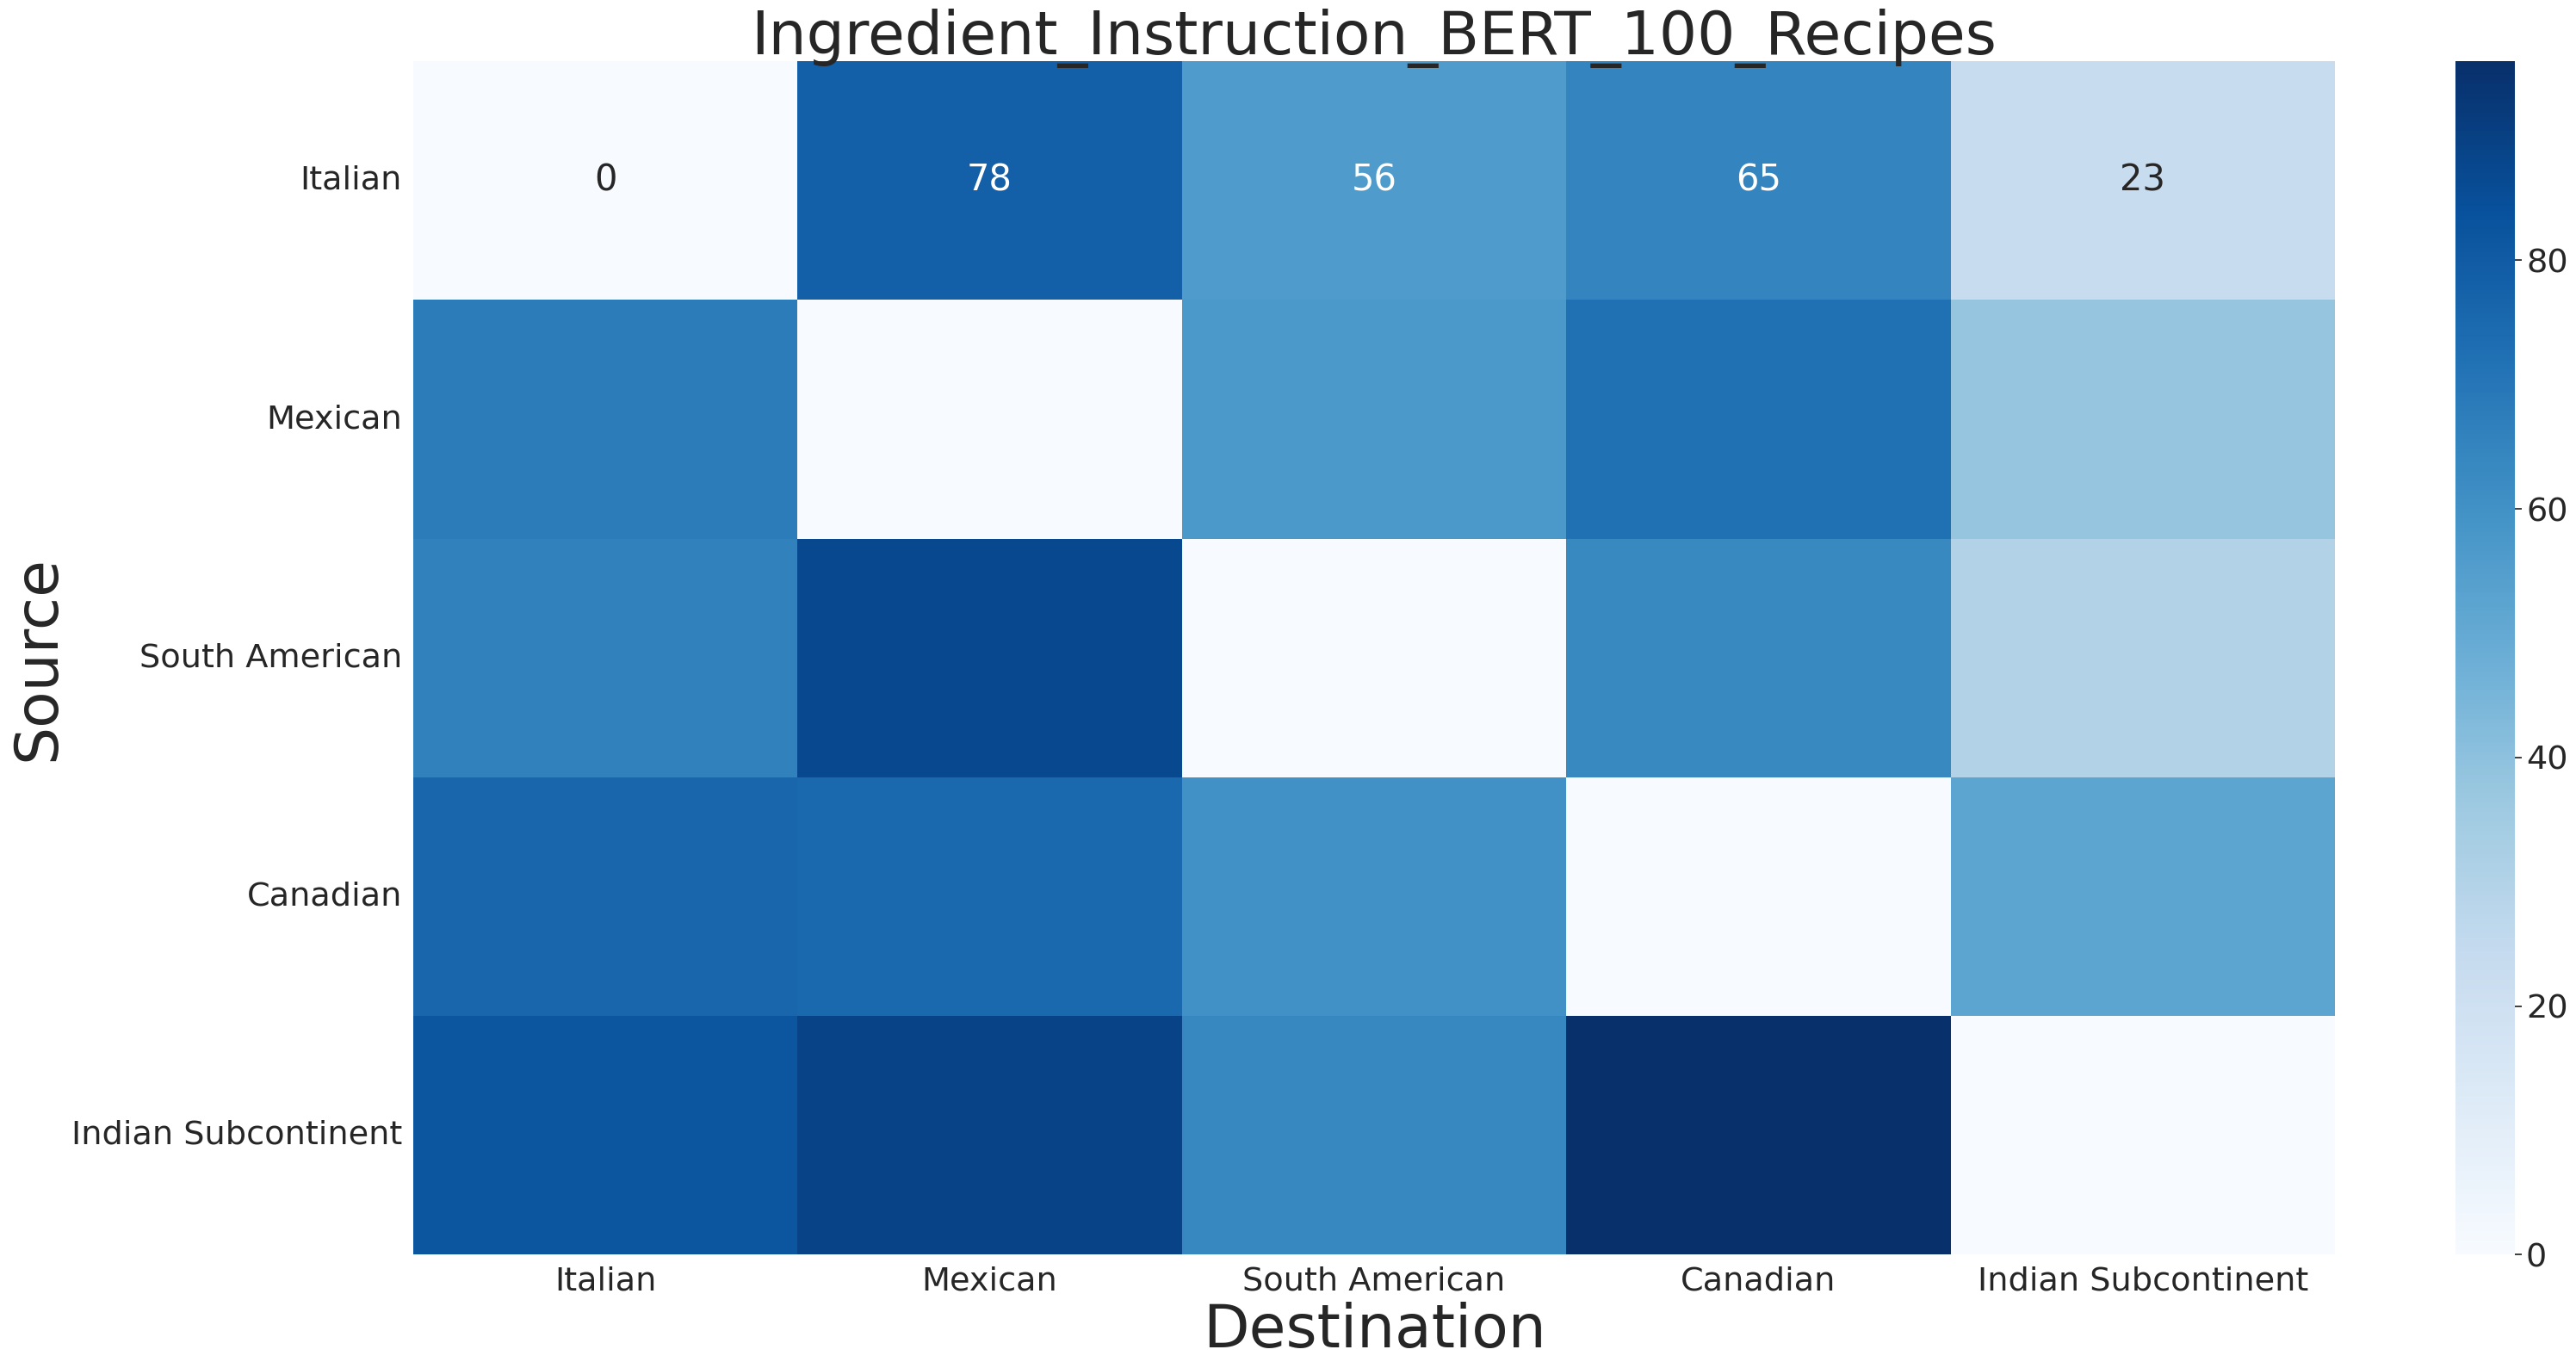

In [19]:
df_cm = pd.DataFrame(matrix, index = [i.replace('_',' ') for i in cuisine_list], columns = [i.replace('_',' ') for i in cuisine_list])
  
plt.figure(figsize = (36,18))
sn.set(font_scale=2.5)
g = sn.heatmap(df_cm, annot=True, annot_kws={"size": 30},cmap = "Blues")
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.title("Ingredient_Instruction_BERT_"+str(recipes_to_transform)+"_Recipes",fontsize = 50)
plt.xlabel("Destination",fontsize = 50)
plt.ylabel("Source",fontsize = 50)
# Recipe Transformation Performance 
plt.savefig('confusion_matrix_'+str(total_data)+'.png', dpi = 300)
